In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 01 Merge human review with llm judge data

In [2]:
# Load LLM judge and human review CSV files
llm_df = pd.read_csv("llm_judge.csv")
human_df = pd.read_csv("human_review.csv")

In [3]:
# Rename LLM judge columns to distinguish them after merge
llm_df = llm_df.rename(columns={
    "Clarity": "Clarity_llm",
    "Novelty": "Novelty_llm",
    "Soundness": "Soundness_llm",
    "Significance": "Significance_llm",
    "Overall": "Overall_llm"
})

# Rename human review columns to distinguish them after merge
human_df = human_df.rename(columns={
    "Clarity": "Clarity_human",
    "Novelty": "Novelty_human",
    "Soundness": "Soundness_human",
    "Significance": "Significance_human",
    "Overall": "Overall_human"
})

In [4]:
# Add an empty Confidence_human column as placeholder
human_df["Confidence_human"] = ""

In [5]:
# Merge the human reviews with the LLM judge scores
# Each (workshop_name, model_name) pair in llm_df should match two rows in human_df
merged_df = pd.merge(
    human_df, llm_df,
    how="left",
    on=["workshop_name", "model_name"],
)


In [6]:
merged_df.head(10)

,reviewer_id,model_name,workshop_name,Novelty_human,Clarity_human,Soundness_human,Significance_human,Overall_human,Confidence_human,model,Clarity_llm,Novelty_llm,Soundness_llm,Significance_llm,Overall_llm
0,1,claude,iclr2025_data_problems,6,6,4,5,4,,A,7.5,7.5,5.0,7.5,6.0
1,1,claude,iclr2025_dl4c,4,4,6,3,4,,A,8.0,7.0,5.0,6.0,5.5
2,1,claude,iclr2025_scsl,7,5,4,4,3,,A,7.5,7.0,3.0,4.0,3.5
3,1,gemini,iclr2025_data_problems,7,6,7,7,7,,B,8.0,7.5,5.5,7.0,6.0
4,1,gemini,iclr2025_dl4c,6,7,7,7,7,,B,8.0,7.0,2.5,4.0,3.0
5,1,gemini,iclr2025_scsl,7,7,6,6,5,,B,7.0,7.0,3.0,4.5,3.5
6,1,o4-mini,iclr2025_data_problems,5,3,3,5,4,,C,8.0,6.5,2.5,4.0,2.5
7,1,o4-mini,iclr2025_scsl,7,3,2,7,3,,C,7.5,7.5,4.5,6.0,4.5
8,1,o4-mini,iclr2025_scsl,7,3,2,6,4,,C,7.5,7.5,4.5,6.0,4.5
9,2,claude,iclr2025_data_problems,6,7,2,3,2,,A,7.5,7.5,5.0,7.5,6.0


In [7]:
# Save the merged result to a new CSV file
merged_df.to_csv("merge_data.csv", index=False)

# 02 Compute the agreement score

In [8]:
from scipy.stats import mannwhitneyu

df = pd.read_csv('merge_data.csv')
criteria = ['Novelty', 'Clarity', 'Soundness', 'Significance', 'Overall']

## Storage dictionaries for vectors across all workshop+model
human_vs_human_vectors = {crit: [] for crit in criteria}
human_vs_llm_vectors = {crit: [] for crit in criteria}

# Group by workshop and model
for (workshop, model), group in df.groupby(['workshop_name', 'model_name']):
    reviewers = group['reviewer_id'].unique()
    
    # Collect human-human pairs if more than 1 reviewer exists
    if len(reviewers) >= 2:
        pairs = group.groupby('reviewer_id')
        reviewer_scores = [pairs.get_group(r) for r in reviewers]
        
        # Take all possible reviewer pairs
        for i in range(len(reviewer_scores)):
            for j in range(i + 1, len(reviewer_scores)):
                r1 = reviewer_scores[i]
                r2 = reviewer_scores[j]
                for crit in criteria:
                    v1 = r1[f'{crit}_human'].values
                    v2 = r2[f'{crit}_human'].values
                    if len(v1) == len(v2):
                        diffs = np.abs(v1 - v2)
                        human_vs_human_vectors[crit].extend(diffs)

    # Collect human-llm pairs
    for _, row in group.iterrows():
        for crit in criteria:
            human_score = row[f'{crit}_human']
            llm_score = row[f'{crit}_llm']
            diff = np.abs(human_score - llm_score)
            human_vs_llm_vectors[crit].append(diff)

# Perform Mann-Whitney U tests comparing the two groups for each criterion
results = []
for crit in criteria:
    human_human = human_vs_human_vectors[crit]
    human_llm = human_vs_llm_vectors[crit]
    if len(human_human) > 0 and len(human_llm) > 0:
        stat, p = mannwhitneyu(human_human, human_llm, alternative='two-sided')
        results.append({
            'criteria': crit,
            'n_human_human': len(human_human),
            'n_human_llm': len(human_llm),
            'statistic': stat,
            'p_value': p
        })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

In [9]:
results_df

,criteria,n_human_human,n_human_llm,statistic,p_value
0,Novelty,24,60,662.5,0.568827
1,Clarity,24,60,525.5,0.052853
2,Soundness,24,60,630.5,0.372652
3,Significance,24,60,603.0,0.241145
4,Overall,24,60,692.0,0.782697


/var/folders/9n/22pg6vwd0pzc_7jwtdwwgm240000gn/T/ipykernel_4359/1040532329.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/9n/22pg6vwd0pzc_7jwtdwwgm240000gn/T/ipykernel_4359/1040532329.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/9n/22pg6vwd0pzc_7jwtdwwgm240000gn/T/ipykernel_4359/1040532329.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/9n/22pg6vwd0pzc_7jwtdwwgm240000gn/T/ipykernel_4359/1040532329.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

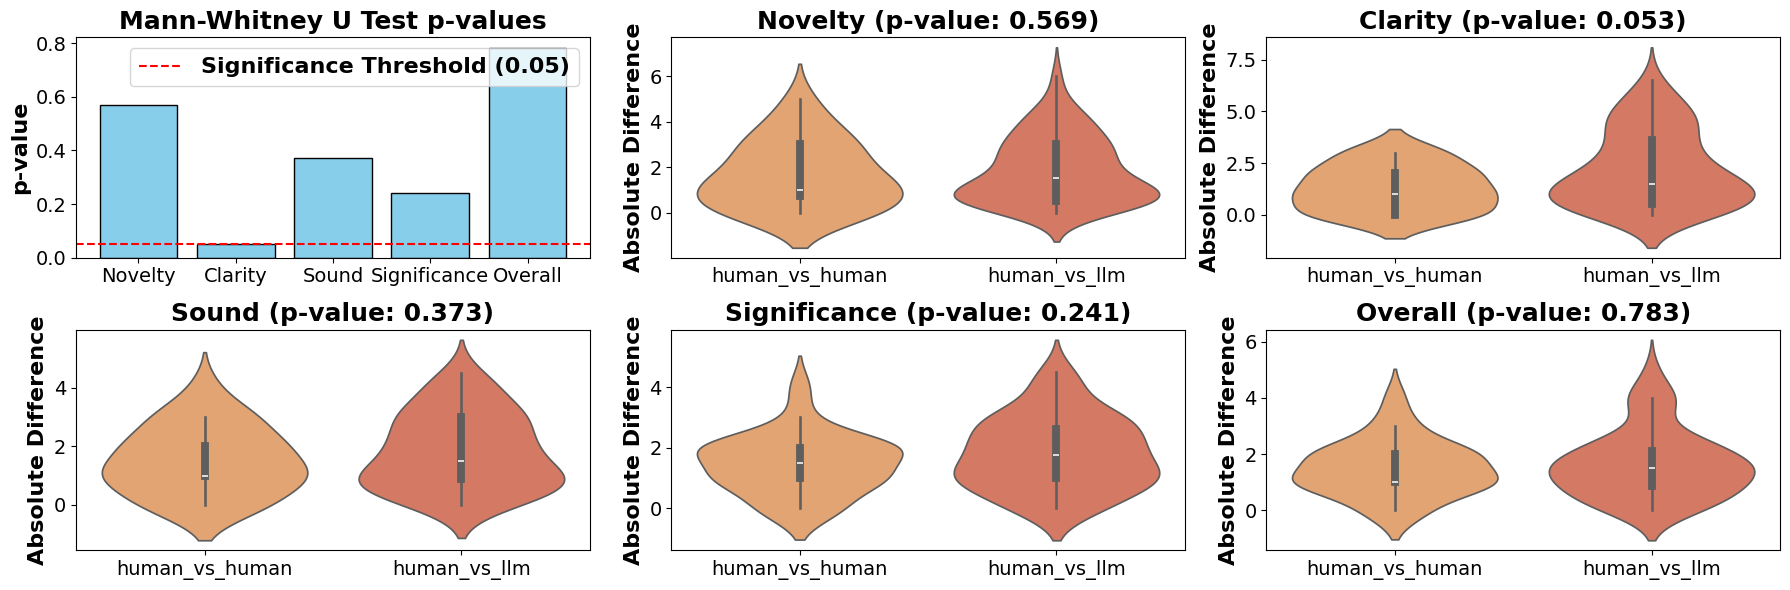

In [10]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns

# define the colors for the bar chart and violin plots
bar_color = 'skyblue'  # the color for the bar chart
violin_palette = ['#F4A261', '#E76F51']  # Violin plot orange contrast

pdf_path_adjusted = 'human_vs_llm_reviewer_comparison.pdf'
with PdfPages(pdf_path_adjusted) as pdf:
    fig, axes = plt.subplots(2, 3, figsize=(18, 6))
    axes = axes.flatten()

    # Plot the p-values from the Mann-Whitney U tests   
    p_values = results_df.set_index('criteria')['p_value']
    new_index = ['Novelty', 'Clarity', 'Sound', 'Significance', 'Overall']
    axes[0].bar(new_index, p_values.values, color=bar_color, edgecolor='black')
    axes[0].axhline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
    axes[0].set_title('Mann-Whitney U Test p-values', fontsize=18, fontweight='bold')
    axes[0].set_ylabel('p-value', fontsize=16, fontweight='bold')
    axes[0].tick_params(axis='both', labelsize=14)
    legend = axes[0].legend(fontsize=16, loc='upper right')
    for text in legend.get_texts():
        text.set_fontweight('bold')

    # Prepare data for plotting
    plot_data = []
    for crit in criteria:
        plot_data.extend([
            {'criteria': crit, 'group': 'human_vs_human', 'difference': val}
            for val in human_vs_human_vectors[crit]
        ])
        plot_data.extend([
            {'criteria': crit, 'group': 'human_vs_llm', 'difference': val}
            for val in human_vs_llm_vectors[crit]
        ])

    plot_df = pd.DataFrame(plot_data)

    # Prepare data for violin plots
    for idx, crit in enumerate(['Novelty', 'Clarity', 'Soundness', 'Significance', 'Overall'], start=1):
        sns.violinplot(
            x='group',
            y='difference',
            data=plot_df[plot_df['criteria'] == crit],
            ax=axes[idx],
            palette=violin_palette
        )
        p_val = results_df.loc[results_df['criteria'] == crit, 'p_value'].values[0]
        descip = 'Sound' if crit == 'Soundness' else crit
        axes[idx].set_title(f'{descip} (p-value: {p_val:.3f})', fontsize=18, fontweight='bold')
        axes[idx].set_ylabel('Absolute Difference', fontsize=16, fontweight='bold')
        axes[idx].set_xlabel('')
        axes[idx].tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()
    pdf.savefig(fig)  # Save the current figure into the PDF
    plt.close(fig)
